In [1]:
s3_data ="s3://aegovan-data/processed_dataset/test_unique_pub_v6_max_neg.json"
data_dir = "temp"

s3_model_single_path = "s3://aegovan-data/results/ppi-bert-2020-12-28-06-14-27-510/output/output.tar.gz"
s3_model_path_format = "s3://aegovan-data/results/{}/output/output.tar.gz"

In [2]:
!pip install scikit-plot==0.3.7


You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp  $s3_model_single_path $data_dir

download: s3://aegovan-data/results/ppi-bert-2020-12-28-06-14-27-510/output/output.tar.gz to temp/output.tar.gz


In [4]:
!tar -xf $data_dir/output.tar.gz -C $data_dir


In [5]:
!rm $data_dir/output.tar.gz


In [6]:
!ls -l $data_dir

total 6736
-rw-r--r--  1 aeg  staff  3429287 Dec 28 20:11 predicted.json
-rw-r--r--  1 aeg  staff     5195 Dec 28 20:11 training_scores_epoch_Objectdump_20201228_091137_5b2fdd7a-bc74-4e36-bc75-f5755ed73cf5.json
-rw-r--r--  1 aeg  staff     5207 Dec 28 20:11 validation_scores_epoch_Objectdump_20201228_091137_46491520-fbec-4c90-b025-2889c5c16b7f.json


In [7]:
import tarfile
import pandas as pd
import json
from pandas.io.json import json_normalize
import tempfile 
import os
import boto3
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
import scikitplot as skplt

In [8]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [9]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [10]:
import glob, os

single_test_results_file = os.path.join(data_dir, "predicted.json")
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [11]:
#download_single_file(s3_data, test_input_file)

In [12]:
import pandas as pd

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [14]:
df_single_test_results = pd.read_json(single_test_results_file)
df_single_test_results["actual"] = df_single_test_results["class"]

In [15]:
df_single_test_results.columns


Index(['pubmedId', 'pubmedabstract', 'annotations',
       'num_unique_gene_normalised_id', 'num_gene_normalised_id',
       'normalised_abstract', 'participant1Id', 'participant2Id',
       'gene_to_uniprot_map', 'class', 'predicted', 'confidence_scores',
       'actual'],
      dtype='object')

In [16]:
df_single_test_results.shape

(720, 13)

In [17]:
df_single_test_results.head(n=2)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class,predicted,confidence_scores,actual
0,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,P51817,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.8998707533, 'demethylation'...",other
1,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,O43541,Q02363,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.9299001694000002, 'demethyl...",other


## Analyse Results

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [19]:
df_single_test_results.shape

(720, 13)

In [20]:
def get_softmax_confidence(df):
    import math
    df = df.copy(deep=True)
    keys = list(df["confidence_scores"][0].keys())
    # This is log softmax, convert to softmax prob
    for k in keys:
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
        
     # normalise
    for k in keys:
        df[k]  =df.apply(lambda x: x[k]/sum(x[keys]), axis=1)

    df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]), axis=1 )
    
    return df

def get_f_scores(df):
    from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

    scores = {}
    scores["F1_macro"] = f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["precision_macro"]  = precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["recall_macro"] = recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["F1_micro"]  = f1_score(df["actual"], df["predicted"], average='micro' ,sample_weight=None)  





    scores["accuracy"] = accuracy_score(df["actual"], df["predicted"],sample_weight=None)
    
    
    return scores

def plot_confusion_matrix(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt


    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True , figsize=(5,5),  x_tick_rotation=90)
    plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], figsize=(4,4), normalize=False, x_tick_rotation=90 )
    plt.savefig("confusionmatrix_unnormalised.png", bbox_inches='tight')





In [21]:
df_single_test_results = get_softmax_confidence(df_single_test_results)

In [22]:
df_single_test_results.head(n=3)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class,predicted,confidence_scores,actual,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,predicted_confidence
0,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,P51817,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.8998707533, 'demethylation'...",other,0.000053,0.000031,0.000083,0.000038,0.000074,0.999822,0.196232,0.145641,0.999822
1,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,O43541,Q02363,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.9299001694000002, 'demethyl...",other,0.000051,0.000030,0.000072,0.000038,0.000070,0.999810,0.207866,0.151694,0.999810
10,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,Q92917,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.9229903221, 'demethylation'...",other,0.000051,0.000029,0.000082,0.000038,0.000068,0.999819,0.206731,0.142695,0.999819


In [23]:

get_f_scores(df_single_test_results)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'F1_macro': 0.4907250557774171,
 'precision_macro': 0.5172830719869144,
 'recall_macro': 0.506830321852061,
 'F1_micro': 0.8847222222222222,
 'accuracy': 0.8847222222222222}

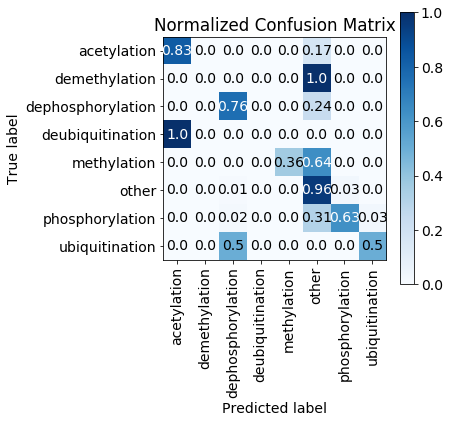

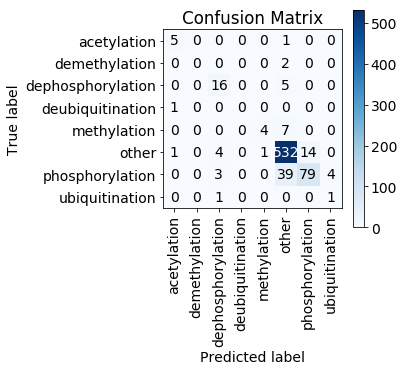

In [24]:
plot_confusion_matrix(df_single_test_results)

In [25]:
def plot_pr_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())
    
    skplt.metrics.plot_precision_recall(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))



In [26]:
def plot_roc_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())


    skplt.metrics.plot_roc(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))





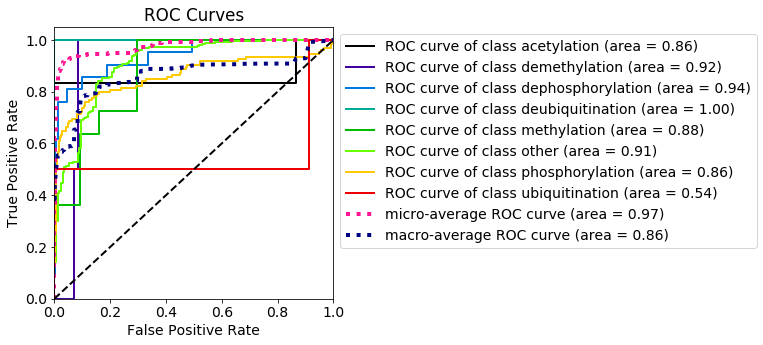

In [27]:
plot_roc_curve(df_single_test_results)

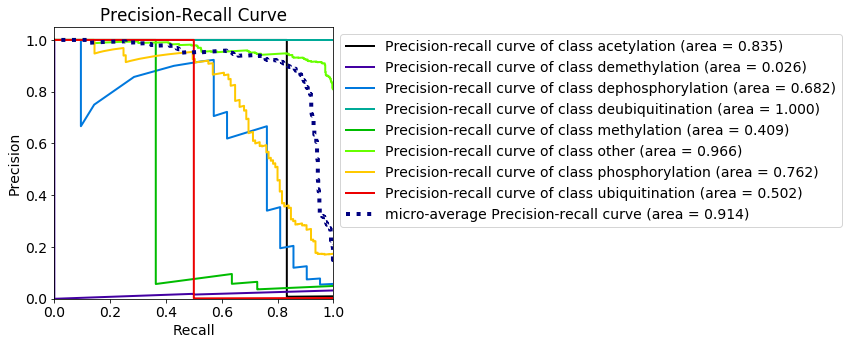

In [28]:
plot_pr_curve(df_single_test_results)


## Training / Validation epoch fit

In [29]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [30]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
55,55,2.786106,98.954802
47,47,3.470903,98.905786
68,68,2.177491,98.826820
48,48,3.285776,98.826603
51,51,3.175052,98.826324
63,63,2.640459,98.805584
56,56,2.328410,98.777761
66,66,1.996192,98.777761
53,53,2.847524,98.762984
57,57,2.183484,98.762874


In [31]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
51,51,39.061941,62.436173
66,66,45.232548,58.801492
45,45,38.929813,58.558534
43,43,36.263244,58.020708
49,49,41.160264,57.985265
47,47,39.118383,57.858866
38,38,40.126620,57.781108
52,52,36.201703,57.742769
67,67,44.436373,57.670660
44,44,37.580549,57.149235


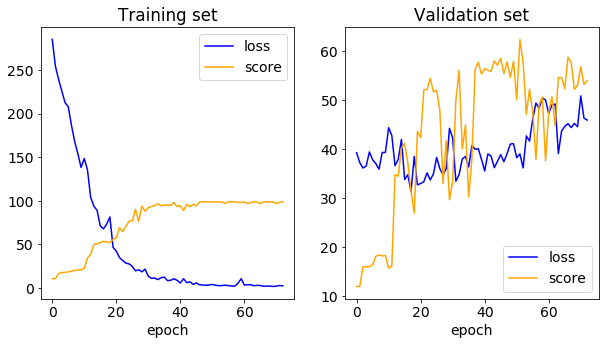

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

## Variation Bert - Objective F-score

In [33]:
import boto3
import re

def search_log(stream_names, filter_pattern, regex_pattern):
    client = boto3.client('logs')

    log_group_name= "/aws/sagemaker/TrainingJobs"

    response = client.filter_log_events(
        logGroupName=log_group_name,
        logStreamNames=stream_names,
        filterPattern= filter_pattern,
        limit=10,
        interleaved=False
    )
    assert len(response["events"]) == 1
    log_message = response["events"][0]["message"]
    
    # extract the cm from string
    prog = re.compile(regex_pattern)
    result = prog.match(log_message)
    
    return result



def get_prf(stream_names, filterPattern):
    regex_pattern = ".*precision, recall, fscore, support\s+\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)

    # normalise string to remove extra space
    result = re.sub("\s+", "", result) 
    
    # split the string, sep by comma..514 62 41 75
    precision, recall, fscore = result.split(",")
    
    return float(precision), float(recall), float(fscore)


    
def get_val_macro_score(stream_names):
    filterPattern =  '"__main__ - INFO - macro average scores"'
    return get_prf(stream_names, filterPattern)

def get_val_micro_score(stream_names):
    filterPattern =  '"__main__ - INFO - micro average scores"'
    return get_prf(stream_names, filterPattern)

def get_log_name(sagemaker_job_name):
    client = boto3.client('logs')
    log_group_name= "/aws/sagemaker/TrainingJobs"
    
    response = client.describe_log_streams(
    logGroupName=log_group_name,
    logStreamNamePrefix=sagemaker_job_name,
    orderBy='LogStreamName',
    descending=False,
    limit=5
)
    assert len(response["logStreams"]) == 1
    
    return  response["logStreams"][0]["logStreamName"]

In [34]:
#precision, recall, fscore
jobs = [
"ppi-bert-2020-12-28-06-14-27-510",
"ppi-bert-2020-12-28-06-13-28-613",
"ppi-bert-2020-12-28-06-12-43-937",
"ppi-bert-2020-12-28-06-11-48-471",
"ppi-bert-2020-12-28-06-10-53-005",
"ppi-bert-2020-12-28-06-10-00-183",
"ppi-bert-2020-12-28-06-09-00-491",
"ppi-bert-2020-12-28-06-08-02-139",
"ppi-bert-2020-12-28-06-07-01-234",
"ppi-bert-2020-12-28-06-06-07-198"
]

In [35]:
import pandas as pd

val_scores = []
for j in jobs:
    l = get_log_name(j)
    precision, recall, fmacro = get_val_macro_score([l])
    fmicro = get_val_micro_score([l])[2]
    val_scores.append({"jobname": j, "precision":precision*100, "recall": recall*100, "f1-macro": fmacro*100,"f1-micro": fmicro*100})

df_val_variation_scores = pd.DataFrame(val_scores)

In [36]:
df_val_variation_scores .describe()

,f1-macro,f1-micro,precision,recall
count,10.000000,10.000000,10.000000,10.000000
mean,58.976415,85.054645,67.657225,55.023272
std,4.408479,2.420086,5.664559,4.919173
min,50.466801,80.601093,59.963091,46.808092
25%,56.940150,83.265027,63.890866,51.164071
50%,59.712560,85.655738,66.952234,56.315789
75%,62.550915,86.612022,70.991676,58.068833
max,63.336060,88.524590,78.308271,62.758682


In [37]:
best_val_job = df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]["jobname"]

In [38]:
df_val_variation_scores.head(n=10)

,f1-macro,f1-micro,jobname,precision,recall
0,62.436173,85.245902,ppi-bert-2020-12-28-06-14-27-510,73.272390,57.543860
1,56.653731,86.612022,ppi-bert-2020-12-28-06-13-28-613,71.482041,50.651629
2,61.176231,83.060109,ppi-bert-2020-12-28-06-12-43-937,63.852898,59.160401
3,53.737135,82.786885,ppi-bert-2020-12-28-06-11-48-471,64.877121,49.733262
4,58.248889,80.601093,ppi-bert-2020-12-28-06-10-53-005,62.263742,55.687433
5,50.466801,86.065574,ppi-bert-2020-12-28-06-10-00-183,59.963091,46.808092
6,63.320556,88.524590,ppi-bert-2020-12-28-06-09-00-491,78.308271,56.944146
7,63.336060,87.158470,ppi-bert-2020-12-28-06-08-02-139,64.004768,62.758682
8,57.799407,83.879781,ppi-bert-2020-12-28-06-07-01-234,69.520579,52.701396
9,62.589163,86.612022,ppi-bert-2020-12-28-06-06-07-198,69.027348,58.243824


In [39]:
df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]

f1-macro                              63.3361
f1-micro                              87.1585
jobname      ppi-bert-2020-12-28-06-08-02-139
precision                             64.0048
recall                                62.7587
Name: 7, dtype: object

In [40]:
from sklearn.metrics import classification_report



def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


def load_scores_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    
def get_predictions(s3_path):
    tmp_dir = tempfile.mkdtemp()
    outfile = os.path.join(tmp_dir, "output.tar.gz" )
    download_single_file(s3_path, outfile)
    tf = tarfile.open(outfile)
    tf.extractall(path=tmp_dir)
    test_input_file = os.path.join(tmp_dir, "predicted.json")


    df_results =  pd.read_json(test_input_file)
    df_results["actual"] = df_results["class"]
    
    validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(tmp_dir))[0]
    train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(tmp_dir))[0]

    df_val_fit = load_scores_as_df(validation_fit_file)
    df_train_fit = load_scores_as_df(train_fit_file)



    return df_results, df_val_fit, df_train_fit



def create_classification_report(actual, pred, labels=None):
    score_report_dict = sklearn.metrics.classification_report(actual, pred, output_dict=True, labels=labels)

    score_report_dict_transformed = []
    
    summary = {}
    for k, v in score_report_dict.items():
        if k in ["accuracy" ]: 
          
            summary[k] = v
        else:

            score_report_dict_transformed.append(
                {
                    "InteractionType" : k,
                    "precision" : v["precision"],
                    "recall" : v["recall"],
                    "f1-score" : v["f1-score"],
                    "support" : v["support"]
                }
            )
        
    return pd.DataFrame(score_report_dict_transformed), summary
    
def get_all_classification_report(list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        labels = list(set(df["actual"].unique().tolist()) - set(['other']))
        df_classification_summary,_ = create_classification_report(df["actual"], df["predicted"], labels=labels)
        df_classification_summary["keypath"] = s3_path
        

        scores.append(df_classification_summary)
        
    return pd.concat(scores)




def get_all_scores (list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        score = {}
        score["key"]=s3_path
        score["F1-score"] = 100*f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Precision"]  =100* precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Recall"] = 100*recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None) 
        score["Accuracy"] = 100*accuracy_score(df["actual"], df["predicted"])  


        scores.append(score)
        
    return pd.DataFrame(scores)


def get_ensemble (list_of_s3_path):
    scores = {}

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        scores[s3_path] = df
        
    return scores

In [41]:
%%time

s3_model_paths = []
for k in jobs:
    s3_path = s3_model_path_format.format(k)
    s3_model_paths.append(s3_path)

df_test_variation_scores =  get_all_scores(s3_model_paths)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

CPU times: user 1.23 s, sys: 404 ms, total: 1.64 s
Wall time: 35.4 s


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
df_test_variation_scores.describe()

,Accuracy,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000
mean,89.180556,51.312071,53.520864,50.739037
std,1.862757,7.112181,8.393154,6.890297
min,84.861111,44.292464,46.355204,42.768283
25%,88.541667,46.491203,48.265402,46.381698
50%,89.652778,49.132304,50.847229,49.380621
75%,90.069444,52.905566,54.491856,52.524550
max,91.805556,67.824898,74.461560,64.610335


In [43]:
df_test_variation_scores.head(n=2)

,Accuracy,F1-score,Precision,Recall,key
0,88.472222,49.072506,51.728307,50.683032,s3://aegovan-data/results/ppi-bert-2020-12-28-...
1,89.722222,45.713517,49.732840,42.768283,s3://aegovan-data/results/ppi-bert-2020-12-28-...


In [44]:
df_test_variation_scores.query("key == '{}'".format(s3_model_path_format.format(best_val_job)))

,Accuracy,F1-score,Precision,Recall,key
7,89.583333,67.824898,74.46156,64.610335,s3://aegovan-data/results/ppi-bert-2020-12-28-...


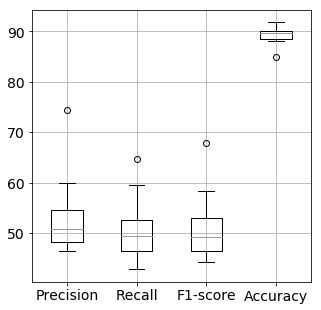

In [45]:

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.style.use('grayscale')

df_test_variation_scores[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax )
#ax.set_title( "BERT Variation - PPI typed dataset" )

plt.savefig("score_variation_typed.eps", bbox_inches='tight')





### Ensemble results

In [46]:
%%time

s3_model_paths = []
for k in jobs:
    job_name = k 
    s3_path = s3_model_path_format.format(job_name)
    s3_model_paths.append(s3_path)

ensemble_results =  get_ensemble(s3_model_paths)

CPU times: user 970 ms, sys: 388 ms, total: 1.36 s
Wall time: 42.7 s


In [47]:
# vote_base="votes_{}"
# def populate_ensemble_predicted_confidence(ensemble_results_dict):
#     ensemble_results = list(ensemble_results_dict.values())
#     base_df= ensemble_results[0]
#     keys = list(base_df["confidence_scores"][0].keys())
#     vote_keys = [ vote_base.format(k) for k in keys]
#     result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id", "num_unique_gene_normalised_id", "num_gene_normalised_id"]  ]
#     result["index"] = base_df.index
#     for v in vote_keys + keys:
#         result[v] = 0.0
#     # This is log softmax, convert to softmax prob
#     for df in ensemble_results:
#         for k in keys:
#             populate_predicted_confidence(df)
        
#             result[k] += df[k]
#             result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)


            
    
#     # populate voting
#     result["ensemble_predicted_confidence"] =  result.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )
#     result["ensemble_predicted"] =  result.apply(lambda r: keys[list(r[ keys]).index(max(r[ keys]))], axis=1  )


#     result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
#     result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
#     return result




In [48]:
# vote_base="votes_{}"
# def populate_ensemble_predicted_confidence(ensemble_results_dict):
#     ensemble_results = list(ensemble_results_dict.values())
#     base_df= ensemble_results[0]
#     keys = list(base_df["confidence_scores"][0].keys())
#     vote_keys = [ vote_base.format(k) for k in keys]
#     result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id", "num_unique_gene_normalised_id", "num_gene_normalised_id"]  ]
#     result["index"] = base_df.index
#     for v in vote_keys :
#         result[v] = 0.0
#     for k in  keys:
#         result[k] = [[]]* result.shape[0]
#     # This is log softmax, convert to softmax prob
#     for df in ensemble_results:
#         populate_predicted_confidence(df)

#         for k in keys:
        
#             result[k] = result[k] + df[k].apply
#             result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)


            
    
# #     # populate voting
# #     result["ensemble_predicted_confidence"] =  result.apply(lambda r: max([sum(scores)/len(scores) for scores in r[ keys]]), axis=1 )
# #     result["ensemble_predicted"] =  result.apply(lambda r: keys[list(r[ keys]).index(max(r[ keys]))], axis=1  )


# #     result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
# #     result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
#     return result

In [49]:
import statistics
import numpy as np

vote_base="votes_{}"
raw_key_base="raw_{}"
def populate_ensemble_predicted_confidence(ensemble_results_dict):
    ensemble_results = list(ensemble_results_dict.values())
    base_df= ensemble_results[0]
    keys = list(base_df["confidence_scores"][0].keys())
    vote_keys = [ vote_base.format(k) for k in keys]
    result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id", "num_unique_gene_normalised_id", "num_gene_normalised_id"]  ]
    result["index"] = base_df.index
    for v in vote_keys :
        result[v] = 0.0
    for k in  keys:
         result[raw_key_base.format(k)] = [[]]* result.shape[0]
      
    # This is log softmax, convert to softmax prob
    for df in ensemble_results:
        df = get_softmax_confidence(df)

        for k in keys:
        
            result[raw_key_base.format(k)] = result[raw_key_base.format(k)] + df[k].apply(lambda x: [x])
            result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)

    
    for k in keys:        
        result[k] = result.apply(lambda r:np.mean(r[raw_key_base.format(k)]), axis=1) 
            
    raw_keys = [raw_key_base.format(k) for k in keys]
    # populate voting
    result["ensemble_predicted_confidence"] =  result.apply(lambda r: max([np.mean(en_score) for en_score in r[ raw_keys]]), axis=1 )
    result["ensemble_predicted"] =  result.apply(lambda r: keys[np.argmax([sum(en_score) for en_score in r[ raw_keys]])], axis=1 )


    result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
    result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
    return result

In [50]:
def get_best_result(df_dict, best_val_key):
    for k in df_dict:
        if best_val_key in k:
            return k,  df_dict[k]
      

In [51]:
k, best_raw_df = get_best_result(ensemble_results, best_val_job)



In [52]:
best_raw_df.head()

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class,predicted,confidence_scores,actual
0,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,P51817,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.9304890633, 'demethylation'...",other
1,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,O43541,Q02363,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.9519498348000002, 'demethyl...",other
10,16491121,To gain insight into the function of human pro...,"[{'start': '37', 'end': '42', 'name': 'human',...",6,21,To gain insight into the function of human P51...,P10451,Q92917,"{'3087': ['Q03014'], '5613': ['P51817', 'A0A02...",other,other,"{'acetylation': -1.9286366701, 'demethylation'...",other
100,9808624,MAP kinase (MAPK) cascades are composed of a M...,"[{'start': '78', 'end': '90', 'name': 'MAPKK k...",5,24,MAP kinase (MAPK) cascades are composed of a M...,P01375,Q13233,"{'4216': ['Q9Y6R4', 'Q9P1M2'], '5599': ['P4598...",other,other,"{'acetylation': -1.8631529808, 'demethylation'...",other
101,9808624,MAP kinase (MAPK) cascades are composed of a M...,"[{'start': '78', 'end': '90', 'name': 'MAPKK k...",5,24,MAP kinase (MAPK) cascades are composed of a M...,P45983,Q13233,"{'4216': ['Q9Y6R4', 'Q9P1M2'], '5599': ['P4598...",other,other,"{'acetylation': -1.9973704815, 'demethylation'...",other


In [53]:
best_df = get_softmax_confidence(best_raw_df)

In [54]:
%%time

df_ensemble = populate_ensemble_predicted_confidence(ensemble_results)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 52.3 s, sys: 1.35 s, total: 53.7 s
Wall time: 1min 2s


In [55]:
df_ensemble.query("ensemble_predicted == 'acetylation'").head(n=3)

,actual,normalised_abstract,participant1Id,participant2Id,num_unique_gene_normalised_id,num_gene_normalised_id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,raw_acetylation,raw_demethylation,raw_dephosphorylation,raw_deubiquitination,raw_methylation,raw_other,raw_phosphorylation,raw_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction
574,acetylation,"The enzyme inositol 1,3,4-trisphosphate 5/6-ki...",Q13572-1,Q92793,4,15,574,7.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,"[0.929372306573888, 0.12817356851323372, 0.382...","[0.08133756493206207, 0.00800661463365498, 0.0...","[0.052234471855481746, 0.023443070049912522, 0...","[0.13537397986532246, 0.016978263264371008, 0....","[0.23117522697575263, 0.04119393843663364, 0.0...","[0.04887367578116677, 0.10862027877825424, 0.0...","[0.27663105060479976, 0.9444020755087468, 0.97...","[0.48747198247577755, 0.2666590054588723, 0.10...",0.689627,0.075474,0.078851,0.085951,0.148831,0.140384,0.467726,0.308796,0.689627,acetylation,acetylation,0.689627
582,acetylation,Np63 is a Q9H3D4 isoform that is predominantly...,O88898-2,Q92831,3,4,582,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.9751220613736735, 0.9876504708207537, 0.949...","[0.125371858386615, 0.08119227185681238, 0.076...","[0.08873971075890318, 0.05031397543011989, 0.0...","[0.16389321145690552, 0.1431704631056725, 0.20...","[0.27024874102646373, 0.17205830423846824, 0.2...","[0.17222032596258308, 0.10878662963622052, 0.0...","[0.10875227146089778, 0.07176549034888456, 0.3...","[0.2865565816465485, 0.3934478545913819, 0.153...",0.937915,0.134743,0.059593,0.140197,0.208696,0.146115,0.173108,0.331813,0.937915,acetylation,acetylation,0.937915
583,acetylation,Np63 is a Q9H3D4 isoform that is predominantly...,O88898-2,Q92831,3,4,583,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.9751220613736735, 0.9876504708207537, 0.949...","[0.125371858386615, 0.08119227185681238, 0.076...","[0.08873971075890318, 0.05031397543011989, 0.0...","[0.16389321145690552, 0.1431704631056725, 0.20...","[0.27024874102646373, 0.17205830423846824, 0.2...","[0.17222032596258308, 0.10878662963622052, 0.0...","[0.10875227146089778, 0.07176549034888456, 0.3...","[0.2865565816465485, 0.3934478545913819, 0.153...",0.937915,0.134743,0.059593,0.140197,0.208696,0.146115,0.173108,0.331813,0.937915,acetylation,acetylation,0.937915


In [56]:
t= "acetylation"
df_ensemble.query(f"ensemble_predicted == '{t}'")[ raw_key_base.format(t)].iloc[0]

[0.929372306573888,
 0.12817356851323372,
 0.382363925155627,
 0.910403590572577,
 0.8464921916294674,
 0.8676751500361481,
 0.8623241957011337,
 0.9758481447880041,
 0.875348027223012,
 0.11827271139637076]

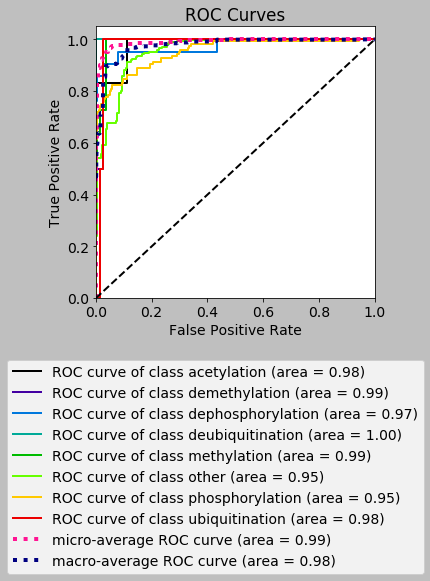

In [57]:

import matplotlib.pyplot as plt
import scikitplot as skplt
keys = list(best_df["confidence_scores"][0].keys())


skplt.metrics.plot_roc(df_ensemble["actual"], df_ensemble[keys], figsize=(5,5)).legend(bbox_to_anchor=(1.2,-0.2))


plt.savefig("plot_roc_ensemble.eps", bbox_inches='tight')


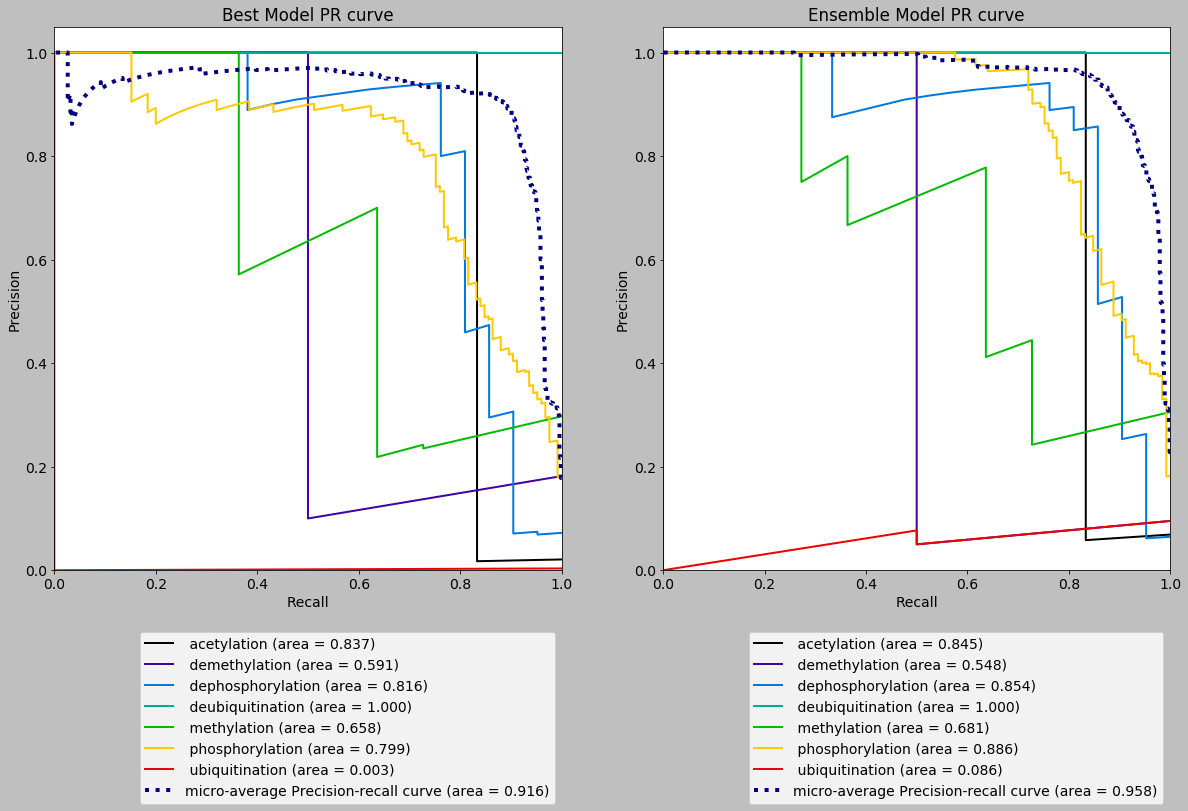

In [58]:

import matplotlib.pyplot as plt
import scikitplot as skplt
classes_to_plot = list( set(list(best_df["confidence_scores"][0].keys()))-set(['other']))

keys = list(best_df["confidence_scores"][0].keys())

fig, ax = plt.subplots(1,2, figsize=(20,10))

axi=ax[0]
skplt.metrics.plot_precision_recall(best_df["actual"], best_df[keys], ax=axi, title="Best Model PR curve", classes_to_plot=classes_to_plot)
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("Precision-recall curve of class","") for l in labels], bbox_to_anchor=(1.0,-0.1))

axi=ax[1]
skplt.metrics.plot_precision_recall(df_ensemble["actual"], df_ensemble[keys], ax=axi,title="Ensemble Model PR curve", classes_to_plot=classes_to_plot).legend(bbox_to_anchor=(1.2,-0.2))
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("Precision-recall curve of class","") for l in labels], bbox_to_anchor=(1.0,-0.1))





plt.savefig("PlotPRCurveOnTest.pdf", bbox_inches='tight')



### Get thresholds to use

In [59]:
import sklearn
from sklearn.preprocessing import label_binarize
import numpy as np 

def get_thrsholds(df, field_actual, classes, confidence_colms):
    result = []
    actual_binarized = label_binarize(df[field_actual], classes=classes)
    predicted_binarized = np.true_divide(df[confidence_colms].values, df[confidence_colms].values.sum(axis=1, keepdims=True)) 
    #predicted_binarized[predicted_binarized < 0.5] = 0.0
    for i in range(actual_binarized.shape[1]):
        
        _, _, thres = sklearn.metrics.precision_recall_curve(actual_binarized[:,i],predicted_binarized[:,i])
  
        best_pr = -1
        pr = []
        rc = []
        for ti, t in enumerate(thres):
            p_full = predicted_binarized[:,i]
            a_full = actual_binarized[:,i]
            #a = a_full[p_full >= t]
            p_label = ( (p_full >= t) & (t > 0.5)).astype(int)
            
#             cut_off = 0.5 if t < 0.5 else t
#             p_label = (p>0.5).astype(int)

            pr.append( sklearn.metrics.precision_score(a_full,p_label, average='binary' ,sample_weight=None))
            rc.append(sklearn.metrics.recall_score(a_full,p_label))
            
            if best_pr < pr[-1]:
                idx =  ti
            if best_pr == 1.0:
                break
            

#         print(keys[i])
#         print(np.round(pr,4))
#         print(np.round(thres,4))



        #get first / lowest index of highest precision
        #last element then it is always one.. so not applicable
        # idx = np.argmax(pr[:-1])
       
        result.append( {
            "key" : keys[i],
            "threshold" :  thres[idx-1],
            "precision" : pr[idx],
            "recall" : rc[idx]
        })
    return result




In [60]:
df_ensemble_best_threshold = pd.DataFrame(get_thrsholds(df_ensemble, field_actual = "actual", classes =keys,confidence_colms=keys ))
df_ensemble_best_threshold

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,key,precision,recall,threshold
0,acetylation,0.0,0.000000,0.406363
1,demethylation,0.0,0.000000,0.065934
2,dephosphorylation,1.0,0.047619,0.513464
3,deubiquitination,0.0,0.000000,0.230605
4,methylation,1.0,0.181818,0.481942
5,other,1.0,0.001812,0.696363
6,phosphorylation,1.0,0.008000,0.858020
7,ubiquitination,0.0,0.000000,0.400855


In [61]:
df_ensemble.query("actual == 'deubiquitination' or ensemble_predicted == 'deubiquitination'")[[ "actual", "ensemble_predicted", "ensemble_predicted_confidence"]].sort_values(by = ["ensemble_predicted_confidence"])

,actual,ensemble_predicted,ensemble_predicted_confidence
690,deubiquitination,ubiquitination,0.855274


### Get Scores

In [62]:
df_ensemble.shape

(720, 35)

In [63]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"],sample_weight=None)
print(scores)



{'F1_macro': 0.47458105793972116, 'precision_macro': 0.5270485476031348, 'recall_macro': 0.4427092038396386, 'F1_micro': 0.9, 'accuracy': 0.9}


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


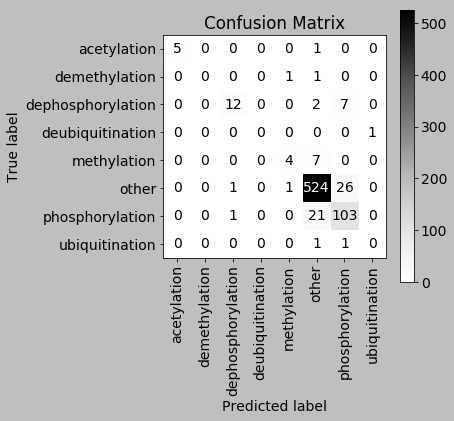

In [64]:
import matplotlib.pyplot as plt
import scikitplot as skplt

fig,ax = plt.subplots(1, 1, figsize=(5,5))


# skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], normalize=True , ax=ax[0],  x_tick_rotation=90)
# plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], ax=ax, normalize=False, x_tick_rotation=90, cmap="Greys" )
plt.savefig("confusionmatrix_unnormalised.eps", bbox_inches='tight')



In [65]:
from sklearn.metrics import confusion_matrix
# Specify label order
labels = ['other', 'acetylation','methylation','demethylation','phosphorylation','dephosphorylation','ubiquitination','deubiquitination'   ] 
confusion_df = pd.DataFrame(data= confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=labels), index=labels, columns=labels)

confusion_df.to_csv("confusion.matrix.csv")


In [66]:
print(confusion_df.to_latex().replace("lation", ".").replace("ination", "."))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  other &  acety. &  methy. &  demethy. &  phosphory. &  dephosphory. &  ubiquit. &  deubiquit. \\
\midrule
other             &    524 &            0 &            1 &              0 &               26 &                  1 &               0 &                 0 \\
acety.       &      1 &            5 &            0 &              0 &                0 &                  0 &               0 &                 0 \\
methy.       &      7 &            0 &            4 &              0 &                0 &                  0 &               0 &                 0 \\
demethy.     &      1 &            0 &            1 &              0 &                0 &                  0 &               0 &                 0 \\
phosphory.   &     21 &            0 &            0 &              0 &              103 &                  1 &               0 &                 0 \\
dephosphory. &      2 &            0 &            0 &              0 &                7 &        

In [67]:
pos_labels = list(set(df_ensemble["actual"].unique().tolist()) - set(['other']))
df_ensemble_classwise_report, summary_ensemble = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
df_ensemble_classwise_report

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,InteractionType,f1-score,precision,recall,support
0,ubiquitination,0.000000,0.000000,0.000000,2
1,deubiquitination,0.000000,0.000000,0.000000,1
2,acetylation,0.909091,1.000000,0.833333,6
3,demethylation,0.000000,0.000000,0.000000,2
4,phosphorylation,0.786260,0.751825,0.824000,125
5,dephosphorylation,0.685714,0.857143,0.571429,21
6,methylation,0.470588,0.666667,0.363636,11
7,micro avg,0.749245,0.760736,0.738095,168
8,macro avg,0.407379,0.467948,0.370343,168
9,weighted avg,0.734009,0.745901,0.738095,168


In [68]:
pos_labels = list(set(best_df["actual"].unique().tolist()) - set(['other']))
best_df_classwise_report, summary_ensemble = create_classification_report(best_df["actual"], best_df["predicted"], labels=pos_labels)
best_df_classwise_report

,InteractionType,f1-score,precision,recall,support
0,ubiquitination,0.000000,0.000000,0.000000,2
1,deubiquitination,1.000000,1.000000,1.000000,1
2,acetylation,0.833333,0.833333,0.833333,6
3,demethylation,0.666667,1.000000,0.500000,2
4,phosphorylation,0.761905,0.830189,0.704000,125
5,dephosphorylation,0.755556,0.708333,0.809524,21
6,methylation,0.470588,0.666667,0.363636,11
7,micro avg,0.743590,0.805556,0.690476,168
8,macro avg,0.641150,0.719789,0.601499,168
9,weighted avg,0.735801,0.797511,0.690476,168


In [69]:
print(df_ensemble_classwise_report.merge( best_df_classwise_report,suffixes= ('.e', '.s'), on="InteractionType" ).drop("support.e", axis=1).sort_values(by=["InteractionType"]).to_latex(index=False, float_format =lambda x: "{:.2%}".format(x)).replace("\\%",""))

\begin{tabular}{lrrrrrrr}
\toprule
   InteractionType &  f1-score.e &  precision.e &  recall.e &  f1-score.s &  precision.s &  recall.s &  support.s \\
\midrule
       acetylation &      90.91 &      100.00 &    83.33 &      83.33 &       83.33 &    83.33 &          6 \\
     demethylation &       0.00 &        0.00 &     0.00 &      66.67 &      100.00 &    50.00 &          2 \\
 dephosphorylation &      68.57 &       85.71 &    57.14 &      75.56 &       70.83 &    80.95 &         21 \\
  deubiquitination &       0.00 &        0.00 &     0.00 &     100.00 &      100.00 &   100.00 &          1 \\
         macro avg &      40.74 &       46.79 &    37.03 &      64.11 &       71.98 &    60.15 &        168 \\
       methylation &      47.06 &       66.67 &    36.36 &      47.06 &       66.67 &    36.36 &         11 \\
         micro avg &      74.92 &       76.07 &    73.81 &      74.36 &       80.56 &    69.05 &        168 \\
   phosphorylation &      78.63 &       75.18 &    82.40 &    

In [70]:
pos_labels = ['acetylation','phosphorylation', 'methylation', 'dephosphorylation']
df_ensemble_sample_size_classwise_report, _ = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
best_df_sample_size_classwise_report,_= create_classification_report(best_df["actual"], best_df["predicted"], labels=pos_labels) 

df_ensemble_sample_size_classwise_report



,InteractionType,f1-score,precision,recall,support
0,acetylation,0.909091,1.000000,0.833333,6
1,phosphorylation,0.786260,0.751825,0.824000,125
2,methylation,0.470588,0.666667,0.363636,11
3,dephosphorylation,0.685714,0.857143,0.571429,21
4,micro avg,0.763077,0.765432,0.760736,163
5,macro avg,0.712913,0.818909,0.648100,163
6,weighted avg,0.756524,0.768782,0.760736,163


In [71]:
print(df_ensemble_sample_size_classwise_report.merge(best_df_sample_size_classwise_report, on="InteractionType", suffixes=[".e", ",b"]).drop("support.e", axis=1).to_latex(index=False, float_format =lambda x: "{:.2%}".format(x)).replace("\\%",""))

\begin{tabular}{lrrrrrrr}
\toprule
   InteractionType &  f1-score.e &  precision.e &  recall.e &  f1-score,b &  precision,b &  recall,b &  support,b \\
\midrule
       acetylation &      90.91 &      100.00 &    83.33 &      83.33 &       83.33 &    83.33 &          6 \\
   phosphorylation &      78.63 &       75.18 &    82.40 &      76.19 &       83.02 &    70.40 &        125 \\
       methylation &      47.06 &       66.67 &    36.36 &      47.06 &       66.67 &    36.36 &         11 \\
 dephosphorylation &      68.57 &       85.71 &    57.14 &      75.56 &       70.83 &    80.95 &         21 \\
         micro avg &      76.31 &       76.54 &    76.07 &      74.75 &       80.28 &    69.94 &        163 \\
         macro avg &      71.29 &       81.89 &    64.81 &      70.53 &       75.96 &    67.76 &        163 \\
      weighted avg &      75.65 &       76.88 &    76.07 &      74.41 &       80.36 &    69.94 &        163 \\
\bottomrule
\end{tabular}



In [72]:
df_ensemble["particpant1Exists"] = df_ensemble.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpant2Exists"] = df_ensemble.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpantsExists"] = df_ensemble.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)




In [73]:
df_ensemble.query("actual != ensemble_predicted  and  particpantsExists"  )[["ensemble_predicted", "actual","normalised_abstract", "participant1Id", "participant2Id"]].sample(n=10)

,ensemble_predicted,actual,normalised_abstract,participant1Id,participant2Id
434,phosphorylation,other,In an effort to clone novel tyrosine-phosphory...,P01106,O75886
570,other,phosphorylation,Q13094 and P22681 are complex adapter proteins...,P12314,P22681
571,other,phosphorylation,Q13094 and P22681 are complex adapter proteins...,P12314,P29353
130,phosphorylation,other,Q8N264 is a newly recognized P21333 (P21333)-b...,Q8N264,P61586
701,other,phosphorylation,Here we show that 14-3-3 proteins bind to P113...,P11309,Q00987
670,other,phosphorylation,"Finding rapid, reversible down-regulation of h...",Q9HAW7,Q02156
708,other,methylation,The post-translational methylation of alpha-am...,P18754,Q9BV86
710,other,methylation,The post-translational methylation of alpha-am...,P18754,Q9BV86
586,phosphorylation,dephosphorylation,P35236 (P35236)/hemopoietic Q92729 is a human ...,P35236,P28482
645,other,methylation,As a critical target for P12004-dependent kina...,P06400,Q8WTS6


In [74]:
df_ensemble.query("not particpantsExists").shape , df_ensemble.query("not particpantsExists and actual != ensemble_predicted").shape, df_ensemble.shape

((52, 38), (10, 38), (720, 38))

In [75]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"],sample_weight=None)
print(scores)



{'F1_macro': 0.5125530651387117, 'precision_macro': 0.5293175977698708, 'recall_macro': 0.5028169348767175, 'F1_micro': 0.9194444444444444, 'accuracy': 0.9194444444444444}


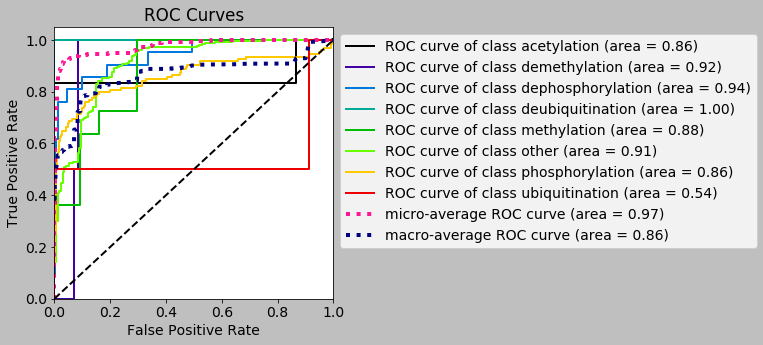

In [76]:
plot_roc_curve(df_single_test_results)

In [77]:
df_ensemble.head(n=2)

,actual,normalised_abstract,participant1Id,participant2Id,num_unique_gene_normalised_id,num_gene_normalised_id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,raw_acetylation,raw_demethylation,raw_dephosphorylation,raw_deubiquitination,raw_methylation,raw_other,raw_phosphorylation,raw_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction,particpant1Exists,particpant2Exists,particpantsExists
0,other,To gain insight into the function of human P51...,P10451,P51817,6,21,0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,"[5.344694479853903e-05, 3.0098593450730335e-05...","[3.085425008605925e-05, 2.0582499747378266e-05...","[8.269309753365332e-05, 3.4657019917488595e-05...","[3.805807030501308e-05, 1.3964855536476683e-05...","[7.438872208607059e-05, 2.438167151024019e-05,...","[0.9998219569744843, 0.9999275370421997, 0.999...","[0.19623154501940981, 0.19558211662409242, 0.2...","[0.1456412670195651, 0.1637845564732296, 0.159...",0.000138,0.000084,0.000217,0.000095,0.000135,0.998969,0.330298,0.163012,0.998969,other,other,0.998969,True,True,True
1,other,To gain insight into the function of human P51...,O43541,Q02363,6,21,1,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,"[5.143656369100171e-05, 2.9235333092134157e-05...","[3.0105991821555157e-05, 1.969371639406488e-05...","[7.154756883364479e-05, 3.269916947473841e-05,...","[3.801578966155934e-05, 1.4412819905724516e-05...","[7.040678469801271e-05, 2.1850541919455558e-05...","[0.9998102460220664, 0.9999240018023233, 0.997...","[0.20786580612946914, 0.19520781265829676, 0.7...","[0.1516939730901386, 0.17808483771832623, 0.07...",0.000155,0.000092,0.000209,0.000105,0.000132,0.997843,0.416817,0.157928,0.997843,other,other,0.997843,True,True,True


In [78]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

def probability_threshold(df, confidence_field, predicted_field):
    result = []
    l, u = min(df[confidence_field]), max(df[confidence_field])
    threshold = 0
    step = round( (u-0)/50, 2)
    majority_class = df.groupby(["actual"]).size().idxmax()
    max_valuecounts =  df.groupby(["actual"]).size().max()
    while threshold <= u :
        df_filter = df.query("{} >=  {}".format(confidence_field, threshold))
        max_valuecounts_filter = df_filter.query("actual == '{}'".format(majority_class)).shape[0]


        result.append ({
            "baseline_accuracy" : max_valuecounts/df.shape[0],
            "baseline_accuracy_threshold" : max_valuecounts_filter/df_filter.shape[0],
            "threshold" : threshold,
            "records" : df_filter.shape[0],
            "percentage_records_retained" : df_filter.shape[0]/df.shape[0],
            "normalised_threshold" : (threshold -0 )/(u-0),
            "F1_macro": f1_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None)  ,
            "precision_macro":precision_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "recall_macro": recall_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "F1_micro":    f1_score(df_filter["actual"], df_filter[predicted_field], average='micro' ,sample_weight=None) ,
            "accuracy":accuracy_score(df_filter["actual"], df_filter[predicted_field],sample_weight=None)
        })
        threshold += step
        
    return pd.DataFrame(result)



In [79]:
pt_ensemble_majority_prediction = probability_threshold(df_ensemble,"ensemble_confidence_majority_prediction", "ensemble_majority_prediction")
pt_ensemble_prediction = probability_threshold(df_ensemble,"ensemble_predicted_confidence", "ensemble_predicted")
pt_best_prediction = probability_threshold(best_df,"predicted_confidence", "predicted")

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


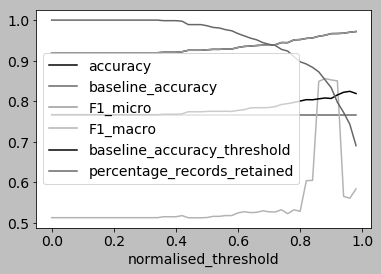

In [80]:
pt_ensemble_majority_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" ,"F1_micro", "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold")

In [81]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=False).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
49,0.583631,0.971831,0.971831,0.766667,0.818913,0.980334,0.690278,0.593349,0.575610,497,0.98
48,0.560542,0.970093,0.970093,0.766667,0.824299,0.960327,0.743056,0.590775,0.536017,535,0.96
47,0.565167,0.967626,0.967626,0.766667,0.821942,0.940320,0.772222,0.588143,0.545553,556,0.94
46,0.850046,0.966899,0.966899,0.766667,0.815331,0.920314,0.797222,0.986030,0.775702,574,0.92
45,0.852435,0.966667,0.966667,0.766667,0.806667,0.900307,0.833333,0.986506,0.779518,600,0.90
44,0.855717,0.962541,0.962541,0.766667,0.807818,0.880300,0.852778,0.982058,0.784456,614,0.88
43,0.848612,0.960191,0.960191,0.766667,0.805732,0.860293,0.872222,0.956940,0.791287,628,0.86
42,0.604606,0.955975,0.955975,0.766667,0.803459,0.840286,0.883333,0.683055,0.562849,636,0.84
41,0.603863,0.954829,0.954829,0.766667,0.803738,0.820280,0.891667,0.682852,0.561711,642,0.82
40,0.528294,0.952012,0.952012,0.766667,0.800310,0.800273,0.897222,0.597129,0.491690,646,0.80


In [82]:
df_ensemble.query("ensemble_confidence_majority_prediction > 12095")["actual"].value_counts()

Series([], Name: actual, dtype: int64)

In [83]:
df_ensemble.to_json("test_ensemble.json")

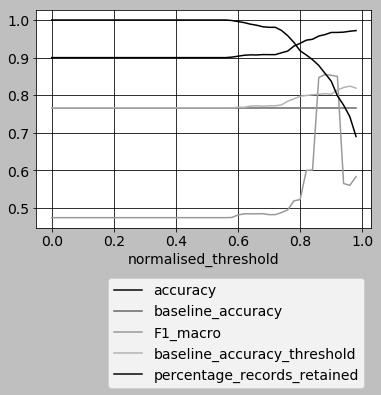

In [84]:
pt_ensemble_prediction   [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_ensmebl.png", bbox_inches='tight')

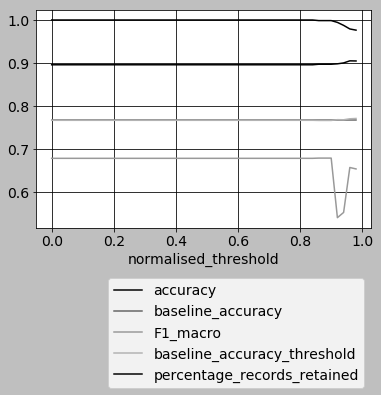

In [85]:
pt_best_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_best.png", bbox_inches='tight')

In [86]:
pt_ensemble_prediction.sort_values(by=["threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.474581,0.9,0.9,0.766667,0.766667,0.000000,1.0,0.527049,0.442709,720,0.00
1,0.474581,0.9,0.9,0.766667,0.766667,0.020007,1.0,0.527049,0.442709,720,0.02
2,0.474581,0.9,0.9,0.766667,0.766667,0.040014,1.0,0.527049,0.442709,720,0.04
3,0.474581,0.9,0.9,0.766667,0.766667,0.060020,1.0,0.527049,0.442709,720,0.06
4,0.474581,0.9,0.9,0.766667,0.766667,0.080027,1.0,0.527049,0.442709,720,0.08
5,0.474581,0.9,0.9,0.766667,0.766667,0.100034,1.0,0.527049,0.442709,720,0.10
6,0.474581,0.9,0.9,0.766667,0.766667,0.120041,1.0,0.527049,0.442709,720,0.12
7,0.474581,0.9,0.9,0.766667,0.766667,0.140048,1.0,0.527049,0.442709,720,0.14
8,0.474581,0.9,0.9,0.766667,0.766667,0.160055,1.0,0.527049,0.442709,720,0.16
9,0.474581,0.9,0.9,0.766667,0.766667,0.180061,1.0,0.527049,0.442709,720,0.18


In [87]:
pt_best_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.678249,0.895833,0.895833,0.766667,0.766667,0.000000,1.0,0.744616,0.646103,720,0.00
1,0.678249,0.895833,0.895833,0.766667,0.766667,0.020001,1.0,0.744616,0.646103,720,0.02
2,0.678249,0.895833,0.895833,0.766667,0.766667,0.040002,1.0,0.744616,0.646103,720,0.04
3,0.678249,0.895833,0.895833,0.766667,0.766667,0.060003,1.0,0.744616,0.646103,720,0.06
4,0.678249,0.895833,0.895833,0.766667,0.766667,0.080004,1.0,0.744616,0.646103,720,0.08
5,0.678249,0.895833,0.895833,0.766667,0.766667,0.100005,1.0,0.744616,0.646103,720,0.10
6,0.678249,0.895833,0.895833,0.766667,0.766667,0.120006,1.0,0.744616,0.646103,720,0.12
7,0.678249,0.895833,0.895833,0.766667,0.766667,0.140007,1.0,0.744616,0.646103,720,0.14
8,0.678249,0.895833,0.895833,0.766667,0.766667,0.160008,1.0,0.744616,0.646103,720,0.16
9,0.678249,0.895833,0.895833,0.766667,0.766667,0.180009,1.0,0.744616,0.646103,720,0.18


In [88]:
k

's3://aegovan-data/results/ppi-bert-2020-12-28-06-08-02-139/output/output.tar.gz'

In [89]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.512553,0.919444,0.919444,0.766667,0.766667,0.000000,1.0,0.529318,0.502817,720,0.00
1,0.512553,0.919444,0.919444,0.766667,0.766667,0.020007,1.0,0.529318,0.502817,720,0.02
2,0.512553,0.919444,0.919444,0.766667,0.766667,0.040014,1.0,0.529318,0.502817,720,0.04
3,0.512553,0.919444,0.919444,0.766667,0.766667,0.060020,1.0,0.529318,0.502817,720,0.06
4,0.512553,0.919444,0.919444,0.766667,0.766667,0.080027,1.0,0.529318,0.502817,720,0.08
5,0.512553,0.919444,0.919444,0.766667,0.766667,0.100034,1.0,0.529318,0.502817,720,0.10
6,0.512553,0.919444,0.919444,0.766667,0.766667,0.120041,1.0,0.529318,0.502817,720,0.12
7,0.512553,0.919444,0.919444,0.766667,0.766667,0.140048,1.0,0.529318,0.502817,720,0.14
8,0.512553,0.919444,0.919444,0.766667,0.766667,0.160055,1.0,0.529318,0.502817,720,0.16
9,0.512553,0.919444,0.919444,0.766667,0.766667,0.180061,1.0,0.529318,0.502817,720,0.18


## Gene mentions impact

In [90]:
print(df_ensemble.query("actual != 'other'")["num_unique_gene_normalised_id"].describe(percentiles= [ f/100 for f in range(0,110, 10)]).to_latex(float_format = lambda x:  '{:.2f}'.format(x)))

\begin{tabular}{lr}
\toprule
{} &  num\_unique\_gene\_normalised\_id \\
\midrule
count &                         168.00 \\
mean  &                           3.54 \\
std   &                           1.83 \\
min   &                           1.00 \\
0\%    &                           1.00 \\
10\%   &                           1.00 \\
20\%   &                           2.00 \\
30\%   &                           2.00 \\
40\%   &                           3.00 \\
50\%   &                           3.00 \\
60\%   &                           4.00 \\
70\%   &                           5.00 \\
80\%   &                           5.00 \\
90\%   &                           6.00 \\
100\%  &                           9.00 \\
max   &                           9.00 \\
\bottomrule
\end{tabular}



In [91]:
df_ensemble.query("actual != 'other'")\
.groupby(["actual"])["num_unique_gene_normalised_id"]\
.describe(percentiles= [ f/100 for f in range(0,110, 10)])

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
actual,,,,,,,,,,,,,,,,
acetylation,6.0,3.500000,1.378405,2.0,2.0,2.5,3.0,3.0,3.0,3.0,3.0,3.5,4.0,5.0,6.0,6.0
demethylation,2.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
dephosphorylation,21.0,3.619048,1.687489,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,5.0,6.0,6.0,6.0,6.0
deubiquitination,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
methylation,11.0,2.818182,0.404520,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
phosphorylation,125.0,3.560000,1.952666,1.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,5.0,5.0,6.0,9.0,9.0
ubiquitination,2.0,5.000000,1.414214,4.0,4.0,4.2,4.4,4.6,4.8,5.0,5.2,5.4,5.6,5.8,6.0,6.0


In [92]:
print(df_ensemble.query("actual != 'other'")\
.groupby(["actual"])["num_unique_gene_normalised_id"]\
.describe()\
.to_latex(float_format = lambda x:  '{:.2f}'.format(x)))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &  mean &  std &  min &  25\% &  50\% &  75\% &  max \\
actual            &        &       &      &      &      &      &      &      \\
\midrule
acetylation       &   6.00 &  3.50 & 1.38 & 2.00 & 3.00 & 3.00 & 3.75 & 6.00 \\
demethylation     &   2.00 &  5.00 & 0.00 & 5.00 & 5.00 & 5.00 & 5.00 & 5.00 \\
dephosphorylation &  21.00 &  3.62 & 1.69 & 2.00 & 2.00 & 3.00 & 5.00 & 6.00 \\
deubiquitination  &   1.00 &  2.00 &  nan & 2.00 & 2.00 & 2.00 & 2.00 & 2.00 \\
methylation       &  11.00 &  2.82 & 0.40 & 2.00 & 3.00 & 3.00 & 3.00 & 3.00 \\
phosphorylation   & 125.00 &  3.56 & 1.95 & 1.00 & 2.00 & 3.00 & 5.00 & 9.00 \\
ubiquitination    &   2.00 &  5.00 & 1.41 & 4.00 & 4.50 & 5.00 & 5.50 & 6.00 \\
\bottomrule
\end{tabular}



In [93]:
from datetime import datetime
def summarize_impact_unique_gene_count(df):
    
    size_genes = df ["num_unique_gene_normalised_id"] .unique().tolist()
    
    pos_labels = list(set(df["actual"].unique().tolist()) - set(['other']))

    frames =[]
    for i in  size_genes:
        print(datetime.now(),"Running for size ", i)
        
        df_size = df.query("num_unique_gene_normalised_id == {}".format(i))

        df_class_wise_report,_ = create_classification_report(df_size["actual"], df_size["ensemble_predicted"], labels=pos_labels)
        
        df_class_wise_report["unique_gene_count"] = i
        
        frames.append(df_class_wise_report)
        
    df = pd.concat(frames)
    
    return df


In [94]:
df_size_summary = summarize_impact_unique_gene_count(df_ensemble)

2020-12-28 22:03:13.832314 Running for size  6
2020-12-28 22:03:13.849047 Running for size  5
2020-12-28 22:03:13.863723 Running for size  4
2020-12-28 22:03:13.871036 Running for size  7
2020-12-28 22:03:13.879245 Running for size  3
2020-12-28 22:03:13.887587 Running for size  2
2020-12-28 22:03:13.894574 Running for size  8
2020-12-28 22:03:13.900609 Running for size  9
2020-12-28 22:03:13.907516 Running for size  1


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [95]:
df_size_summary

,InteractionType,f1-score,precision,recall,support,unique_gene_count
0,ubiquitination,0.000000,0.000000,0.000000,1,6
1,deubiquitination,0.000000,0.000000,0.000000,0,6
2,acetylation,0.000000,0.000000,0.000000,1,6
3,demethylation,0.000000,0.000000,0.000000,0,6
4,phosphorylation,0.750000,0.666667,0.857143,14,6
5,dephosphorylation,0.333333,1.000000,0.200000,5,6
6,methylation,0.000000,0.000000,0.000000,0,6
7,micro avg,0.650000,0.684211,0.619048,21,6
8,macro avg,0.154762,0.238095,0.151020,21,6
9,weighted avg,0.579365,0.682540,0.619048,21,6


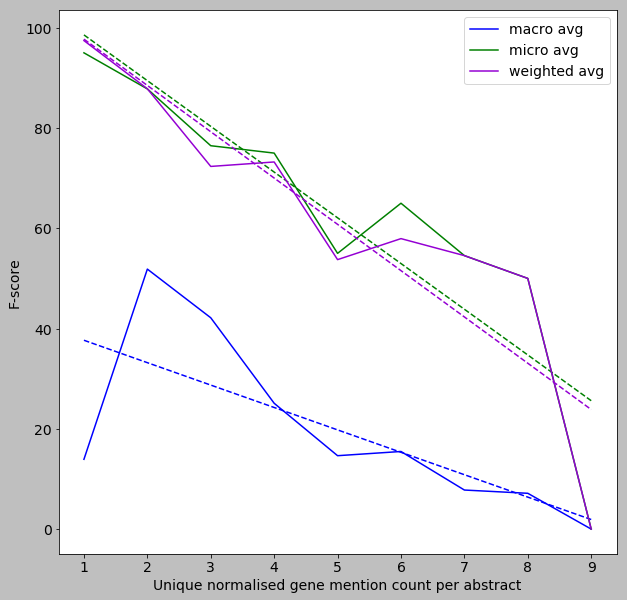

In [96]:
import numpy

fig, ax = plt.subplots(figsize=(10,10))


colors = ['blue', 'green',  "darkviolet"]

for c, (label, df_e) in zip(colors, df_size_summary.query("InteractionType in ['micro avg', 'macro avg', 'weighted avg']").groupby('InteractionType')):
    d = df_e.sort_values(by="unique_gene_count")
    d["f1-score"] = d['f1-score'].apply( lambda x: float( '{:.2%}'.format(x).replace("%", "")) )
    d.plot.line( ax=ax, label=label, x="unique_gene_count" , y="f1-score", color=c  )
    z = numpy.polyfit(d["unique_gene_count"], d["f1-score"], 1)
    p = numpy.poly1d(z)
    plt.plot(  d["unique_gene_count"], p(d["unique_gene_count"]), color=c ,  linestyle='dashed' )
    plt.xlabel("Unique normalised gene mention count per abstract")
    plt.ylabel("F-score")
    
plt.legend()

plt.savefig("GeneCountVsScore.pdf")


plt.show()



## Ensemble size impact

In [97]:
from datetime import datetime
def summarize_impact_ensemble_size(jobs):
    """
    Summarize impact of ensemble_size on prediction
    """
    s3_model_paths = []
    for k in jobs:
        job_name = k 
        s3_path = s3_model_path_format.format(job_name)
        s3_model_paths.append(s3_path)
    
    
    frames = []
    scores = []
    
    for i in range(1, len(s3_model_paths)):
        print(datetime.now(),"Running for ensemble ", i)
        # Compute individual scores
        df_score = get_all_classification_report(s3_model_paths[:i])
        df_score["ensemble_size"] = i
        scores.append(df_score)
        
        #Compute ensemble scores
        ensemble_results =  get_ensemble(s3_model_paths[:i])
        df_ensemble = populate_ensemble_predicted_confidence(ensemble_results)
        
        pos_labels = list(set(df_ensemble["actual"].unique().tolist()) - set(['other']))


        df_class_wise_report,_ = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
        
        df_class_wise_report["ensemble_size"] = i
        
        frames.append(df_class_wise_report)
        
    df = pd.concat(frames)
    df_scores =  pd.concat(scores)
    
    return df, df_scores
        
        

In [98]:
%%time

df_ensemble_size_compare, df_ensemble_scores = summarize_impact_ensemble_size(jobs)

2020-12-28 22:03:14.430572 Running for ensemble  1


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

2020-12-28 22:03:31.510168 Running for ensemble  2


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_lau

2020-12-28 22:03:55.863241 Running for ensemble  3


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

2020-12-28 22:04:35.349663 Running for ensemble  4


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-28 22:05:26.863351 Running for ensemble  5


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-28 22:06:40.746079 Running for ensemble  6


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-28 22:08:00.364235 Running for ensemble  7


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-28 22:09:39.873373 Running for ensemble  8


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-28 22:11:17.676027 Running for ensemble  9


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

CPU times: user 4min 13s, sys: 10.7 s, total: 4min 24s
Wall time: 9min 50s


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [99]:
df_ensemble_scores .query("InteractionType=='{}'".format("phosphorylation")).groupby("ensemble_size").describe()

f1-score                                                    \
                 count      mean       std       min       25%       50%   
ensemble_size                                                              
1                  1.0  0.724771       NaN  0.724771  0.724771  0.724771   
2                  2.0  0.742727  0.025394  0.724771  0.733749  0.742727   
3                  3.0  0.715514  0.050439  0.661088  0.692929  0.724771   
4                  4.0  0.725352  0.045642  0.661088  0.708850  0.739817   
5                  5.0  0.733406  0.043437  0.661088  0.724771  0.754864   
6                  6.0  0.744505  0.047419  0.661088  0.732294  0.757774   
7                  7.0  0.751959  0.047568  0.661088  0.739817  0.760684   
8                  8.0  0.753202  0.044179  0.661088  0.747341  0.761294   
9                  9.0  0.758782  0.044587  0.661088  0.754864  0.761905   

                                  precision                                \
                    75%       max     count      mean       std       min   
ensemble_size                                                               
1              0.724771  0.724771       1.0  0.849462       NaN  0.849462   
2              0.751705  0.760684       2.0  0.832988  0.023298  0.816514   
3              0.742727  0.760684       3.0  0.786320  0.082494  0.692982   
4              0.756319  0.760684       4.0  0.773452  0.072105  0.692982   
5              0.760684  0.765625       5.0  0.768380  0.063466  0.692982   
6              0.764390  0.800000       6.0  0.799576  0.095192  0.692982   
7              0.781153  0.800000       7.0  0.803577  0.087541  0.692982   
8              0.773389  0.800000       8.0  0.806904  0.081591  0.692982   
9              0.796680  0.803419       9.0  0.813068  0.078530  0.692982   

                                                      recall            \
                    25%       50%       75%       max  count      mean   
ensemble_size                                                            
1              0.849462  0.849462  0.849462  0.849462    1.0  0.632000   
2              0.824751  0.832988  0.841225  0.849462    2.0  0.672000   
3              0.754748  0.816514  0.832988  0.849462    3.0  0.658667   
4              0.724382  0.775681  0.824751  0.849462    4.0  0.688000   
5              0.734848  0.748092  0.816514  0.849462    5.0  0.707200   
6              0.738159  0.782303  0.841225  0.955556    6.0  0.704000   
7              0.741470  0.816514  0.838524  0.955556    7.0  0.713143   
8              0.744781  0.822050  0.835007  0.955556    8.0  0.712000   
9              0.748092  0.827586  0.849462  0.955556    9.0  0.716444   

                                                           support         \
                    std    min    25%    50%    75%    max   count   mean   
ensemble_size                                                               
1                   NaN  0.632  0.632  0.632  0.632  0.632     1.0  125.0   
2              0.056569  0.632  0.652  0.672  0.692  0.712     2.0  125.0   
3              0.046188  0.632  0.632  0.632  0.672  0.712     3.0  125.0   
4              0.069742  0.632  0.632  0.672  0.728  0.776     4.0  125.0   
5              0.074103  0.632  0.632  0.712  0.776  0.784     5.0  125.0   
6              0.066741  0.632  0.646  0.700  0.760  0.784     6.0  125.0   
7              0.065553  0.632  0.660  0.712  0.772  0.784     7.0  125.0   
8              0.060776  0.632  0.674  0.708  0.770  0.784     8.0  125.0   
9              0.058393  0.632  0.688  0.712  0.768  0.784     9.0  125.0   

                                                       
               std    min    25%    50%    75%    max  
ensemble_size                                          
1              NaN  125.0  125.0  125.0  125.0  125.0  
2              0.0  125.0  125.0  125.0  125.0  125.0  
3              0.0  125.0  125.0  125.0  125.0  125.0  
4              0.0  125.0 

In [100]:
df_ensemble_size_compare.query("InteractionType not in [ 'weighted avg']").groupby([ 'InteractionType', "ensemble_size"]).head()

,InteractionType,f1-score,precision,recall,support,ensemble_size
0,ubiquitination,0.222222,0.142857,0.500000,2,1
1,deubiquitination,0.000000,0.000000,0.000000,1,1
2,acetylation,0.909091,1.000000,0.833333,6,1
3,demethylation,0.000000,0.000000,0.000000,2,1
4,phosphorylation,0.719665,0.754386,0.688000,125,1
5,dephosphorylation,0.648649,0.750000,0.571429,21,1
6,methylation,0.500000,0.800000,0.363636,11,1
7,micro avg,0.685714,0.734694,0.642857,168,1
8,macro avg,0.428518,0.492463,0.422343,168,1
0,ubiquitination,0.500000,0.500000,0.500000,2,2


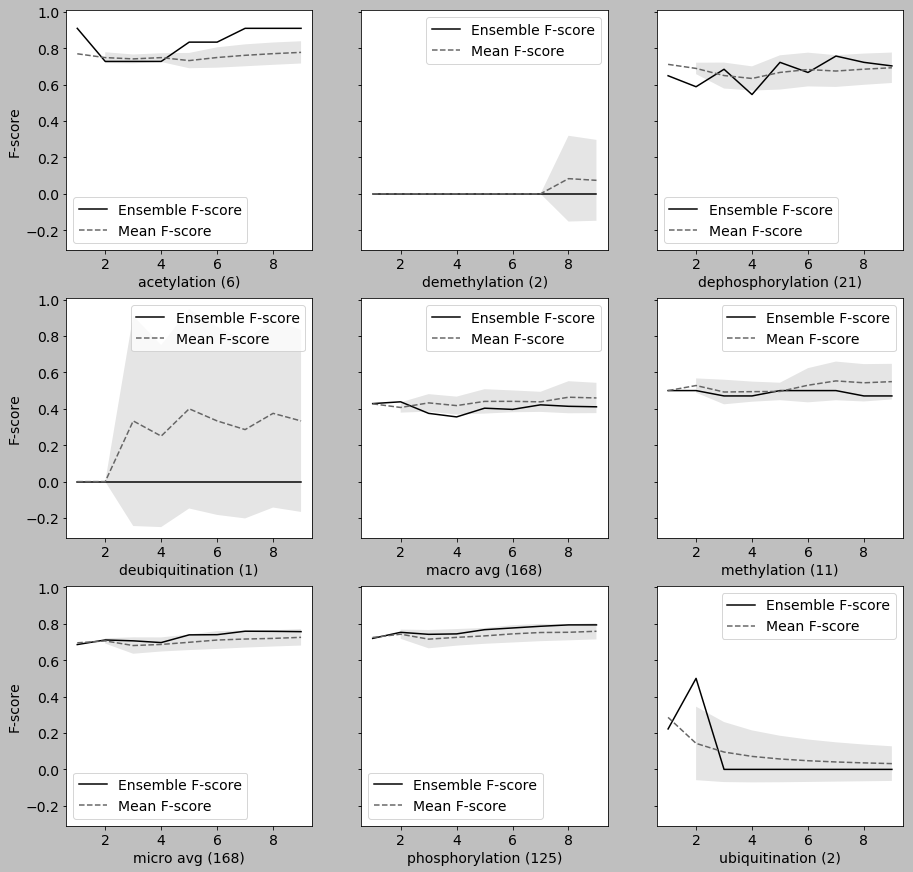

In [101]:
fig, axo = plt.subplots(3,3,figsize=(15,15), sharex=False, sharey=True)
ax=axo.reshape(-1)
colors = ["pink", "red", "blue", "green", "orange", "black", "lime", "mediumblue", "peru"]
line_type = []

for  i, (c, (label, df_e)) in enumerate(zip(colors, df_ensemble_size_compare.query("InteractionType not in [ 'weighted avg']").groupby('InteractionType'))):
    support = df_e["support"].iloc[0]
    df_e = df_e.sort_values(by=["ensemble_size"])


    df_v = df_ensemble_scores.query("InteractionType=='{}'".format(label)).groupby("ensemble_size").std()
    
    df_m = df_ensemble_scores.query("InteractionType=='{}'".format(label)).groupby("ensemble_size").mean()
    
    df_e.plot.line( ax=ax[i],label="Ensemble F-score" , x="ensemble_size" , y="f1-score")
    ax[i].plot(df_m.index.values , df_m["f1-score"].values, linestyle="dashed", label= "{}".format("Mean F-score"))
    ax[i].legend()
    
    ax[i].fill_between( df_v.index.values, df_m["f1-score"].values - df_v["f1-score"].values, df_m["f1-score"].values + df_v["f1-score"].values, alpha=0.1)
    ax[i].set_xlabel( "{} ({})".format(label, str(support))) 
    ax[i].set_ylabel( "F-score") 



plt.savefig("EnsembleSizeImpact.pdf")


plt.show()